In [1]:
import pandas as pd
import os
import warnings
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

plt.style.use('classic')

warnings.filterwarnings('ignore')


In [2]:
random.seed(42)

In [3]:
if os.getcwd().split('/')[-1] != 'market-congestion':
    os.chdir('..')

print(f'working directory: {os.getcwd()}')

working directory: /Users/crinstaniev/Dev/market-congestion


In [17]:
train_data = pd.read_pickle('data/train.pkl')
test_data = pd.read_pickle('data/test.pkl')

# Classification

## Naïve Algorithm

In [18]:
MA_WINDOW = 10

In [19]:
prev_theta = test_data['congested'].shift(1).rolling(window=MA_WINDOW)
congested_count = prev_theta.sum().dropna()

y_pred = congested_count >= 5
y_true = test_data.loc[y_pred.index]['congested']

### Performace Metrics

In [21]:
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [22]:
# this class is only for performance benchmark
class NaiveAlgorithm(BaseEstimator):
    def __init__(self, y_pred):
        self.y_pred = y_pred
        self._estimator_type = 'classifier'
        
    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.y_pred.loc[X].values.astype(int)
    

In [23]:
mdl = NaiveAlgorithm(y_pred=y_pred)

In [24]:
X_test = y_true.index.values

classification report

In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.97      0.88      8435
        True       0.16      0.03      0.04      2031

    accuracy                           0.79     10466
   macro avg       0.48      0.50      0.46     10466
weighted avg       0.68      0.79      0.72     10466



confusion matrix

In [26]:
from sklearn.metrics import plot_confusion_matrix

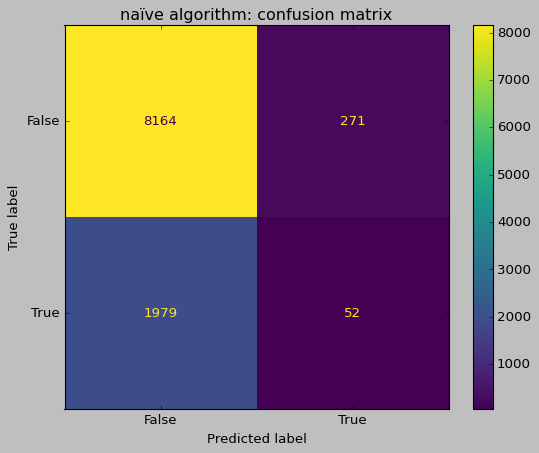

In [27]:
fig, ax = plt.subplots()
plot_confusion_matrix(mdl, X_test, y_true, ax=ax)
ax.set_title('naïve algorithm: confusion matrix')
fig.show()

## Ramdom Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

train_test_dis = pickle.load(open('data/train_test_dis.pkl', 'rb'))

In [39]:
X_train = train_test_dis['X_train_dis'].astype(float)
y_train = train_test_dis['y_train_dis']['congested'].astype(int)
X_test = train_test_dis['X_test_dis'].astype(float)
y_test = train_test_dis['y_test_dis']['congested'].astype(int)

In [40]:
mdl = RandomForestClassifier().fit(X_train, y_train)

In [41]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      8435
           1       0.45      0.02      0.03      2031

    accuracy                           0.81     10466
   macro avg       0.63      0.51      0.46     10466
weighted avg       0.74      0.81      0.72     10466



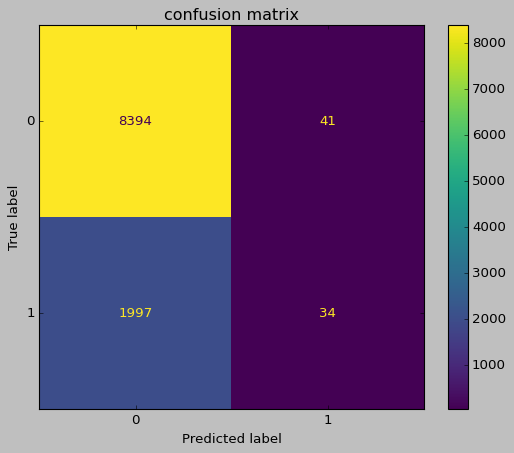

In [42]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

In [43]:
from sklearn.metrics import plot_roc_curve

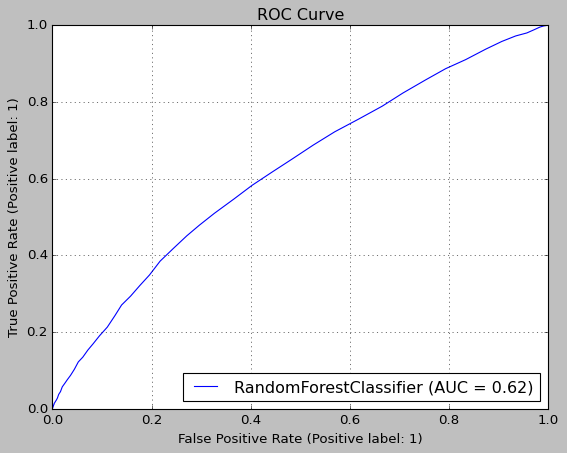

In [44]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Decision tree classifier

In [45]:
mdl = DecisionTreeClassifier().fit(X_train, y_train)

In [46]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      8435
           1       0.24      0.28      0.26      2031

    accuracy                           0.69     10466
   macro avg       0.53      0.53      0.53     10466
weighted avg       0.71      0.69      0.70     10466



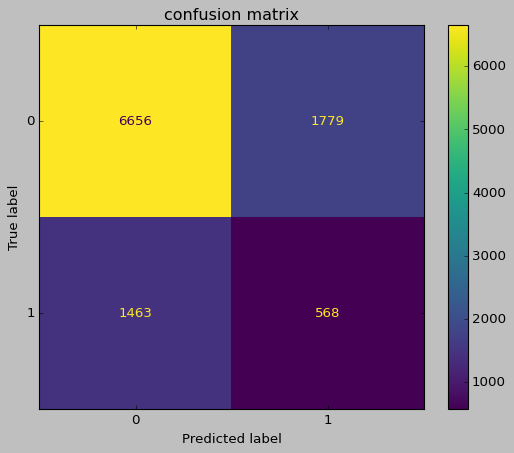

In [47]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

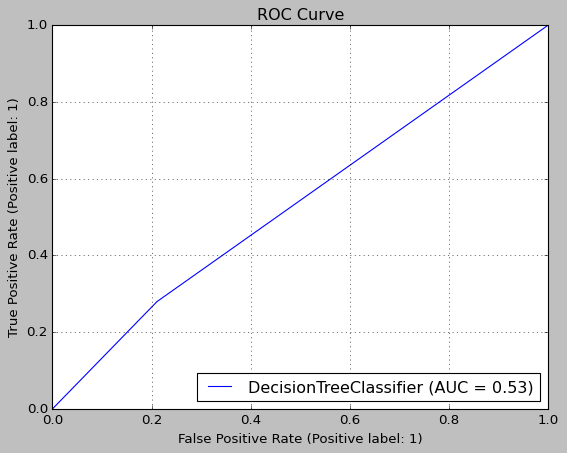

In [48]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## MLP classifier

In [49]:
mdl = MLPClassifier(hidden_layer_sizes=256).fit(X_train, y_train)

In [50]:
print(classification_report(y_test, mdl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      8435
           1       0.37      0.05      0.08      2031

    accuracy                           0.80     10466
   macro avg       0.59      0.51      0.48     10466
weighted avg       0.72      0.80      0.73     10466



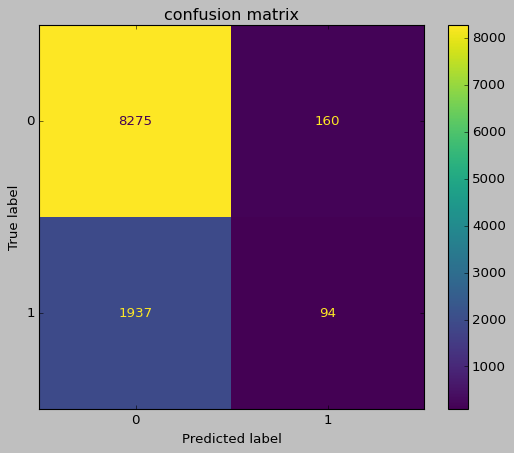

In [51]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.title('confusion matrix')
plt.show()

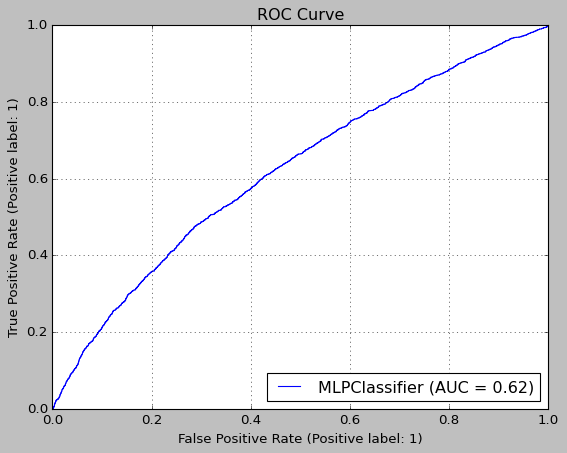

In [52]:
plot_roc_curve(mdl, X_test, y_test)
plt.grid()
plt.title('ROC Curve')
plt.show()

## Auto-ML Classifier

In [53]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [54]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train.values

test_df = pd.DataFrame(X_test)
test_df['target'] = y_test.values

In [55]:
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

In [56]:
predictor = TabularPredictor(
    path='AutogluonModels/classifier',
    label='target'
).fit(train_data)

# predictor = TabularPredictor.load("AutogluonModels/classifier/")

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/classifier/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52766
Train Data Columns: 30
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4294.28 MB
	Train Data (Original)  Memory Usage: 12.66 MB (0.3% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes o

In [57]:
predictor.leaderboard()

                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      NeuralNetFastAI     0.7924       0.030269  420.765436                0.030269         420.765436            1       True          8
1  WeightedEnsemble_L2     0.7924       0.033608  421.256288                0.003339           0.490852            2       True         10
2       NeuralNetTorch     0.7916       0.027251  206.653236                0.027251         206.653236            1       True          9
3       ExtraTreesGini     0.7904       0.062602    1.735914                0.062602           1.735914            1       True          6
4             CatBoost     0.7900       0.004665    3.981746                0.004665           3.981746            1       True          5
5       ExtraTreesEntr     0.7896       0.062823    1.818327                0.062823           1.818327            1       True          7
6     RandomForestGini     

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,0.7924,0.030269,420.765436,0.030269,420.765436,1,True,8
1,WeightedEnsemble_L2,0.7924,0.033608,421.256288,0.003339,0.490852,2,True,10
2,NeuralNetTorch,0.7916,0.027251,206.653236,0.027251,206.653236,1,True,9
3,ExtraTreesGini,0.7904,0.062602,1.735914,0.062602,1.735914,1,True,6
4,CatBoost,0.7900,0.004665,3.981746,0.004665,3.981746,1,True,5
5,ExtraTreesEntr,0.7896,0.062823,1.818327,0.062823,1.818327,1,True,7
6,RandomForestGini,0.7892,0.063826,6.952315,0.063826,6.952315,1,True,3
7,RandomForestEntr,0.7880,0.063012,9.024001,0.063012,9.024001,1,True,4
8,KNeighborsDist,0.7500,2.204642,0.043857,2.204642,0.043857,1,True,2
9,KNeighborsUnif,0.7500,2.413890,0.043270,2.413890,0.043270,1,True,1


In [58]:
y_pred = predictor.predict(test_data)

In [59]:
print(classification_report(test_data['target'], y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      8435
           1       0.47      0.03      0.06      2031

    accuracy                           0.80     10466
   macro avg       0.64      0.51      0.48     10466
weighted avg       0.74      0.80      0.73     10466



In [60]:
# wrapper
class AUTOPredictor(BaseEstimator):
    def __init__(self, classifier):
        self.classifier = classifier
        self._estimator_type = 'classifier'
        
    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.classifier.predict(X)
    
    def predict_proba(self, X):
        return self.classifier.predict_proba(X)
    

In [61]:
mdl = AUTOPredictor(classifier=predictor)

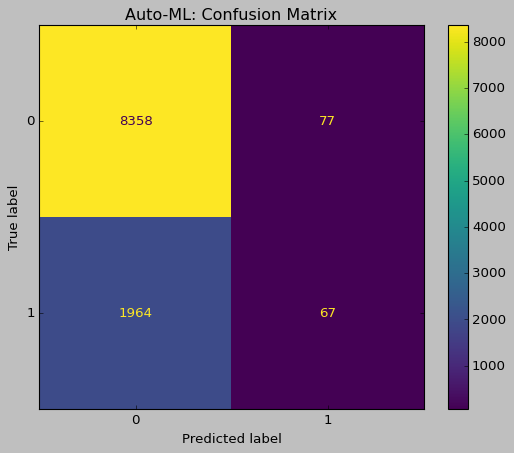

In [62]:
plot_confusion_matrix(mdl, test_data, test_data['target'])
plt.title('Auto-ML: Confusion Matrix')
plt.show()

In [66]:
import sklearn.metrics as metrics
import scikitplot as skplt

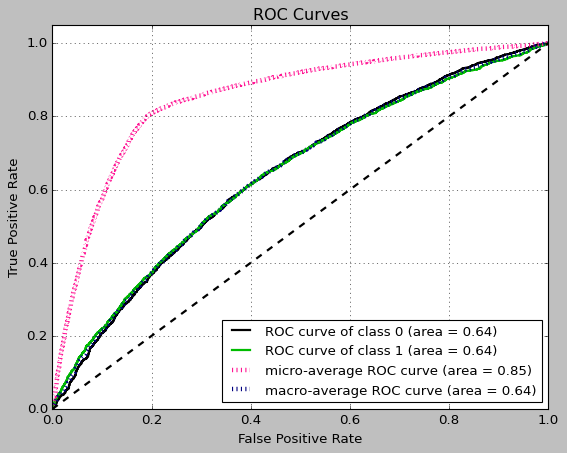

In [67]:
y_probs = predictor.predict_proba(test_data)
preds = y_probs[:][1]
y_true = test_data['target']

skplt.metrics.plot_roc_curve(y_true, y_probs)

plt.grid()
plt.show()


### Classification Under Different Threshold $\gamma$

In [119]:
data_different_gamma_naive = pickle.load(
    open('data/data_different_gamma_naive.pkl', 'rb'))


In [124]:
classification_reports = []

for item in data_different_gamma_naive:
    train_data = item.get('train_df')
    test_data = item.get('test_df')
    gamma = item.get('gamma')

    MA_WINDOW = 10

    prev_theta = test_data['congested'].shift(1).rolling(window=MA_WINDOW)
    congested_count = prev_theta.sum().dropna()

    y_pred = congested_count >= 5
    y_true = test_data.loc[y_pred.index]['congested']

    mdl = NaiveAlgorithm(y_pred=y_pred)

    X_test = y_true.index.values

    classification_reports.append(dict(
        gamma=gamma,
        report=classification_report(y_true, y_pred, output_dict=True)
    ))


In [125]:
pickle.dump(classification_reports, open(
    'data/reports_different_theta.pkl', 'wb'))


# Regression

## Random Forest Regression

In [68]:
from sklearn.ensemble import RandomForestRegressor


In [70]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]


In [71]:
mdl = RandomForestRegressor().fit(
    train_data.loc[:, train_data.columns != 'theta_ma_future'],
    train_data.loc[:, train_data.columns == 'theta_ma_future'],
)


In [72]:
# calculate R2
from sklearn.metrics import r2_score

In [73]:
r2 = r2_score(test_data['theta_ma_future'],
              mdl.predict(
                  test_data.loc[:, train_data.columns != 'theta_ma_future'])
              )
print(f'R2 Score: {r2}')


R2 Score: -0.16119049965841126


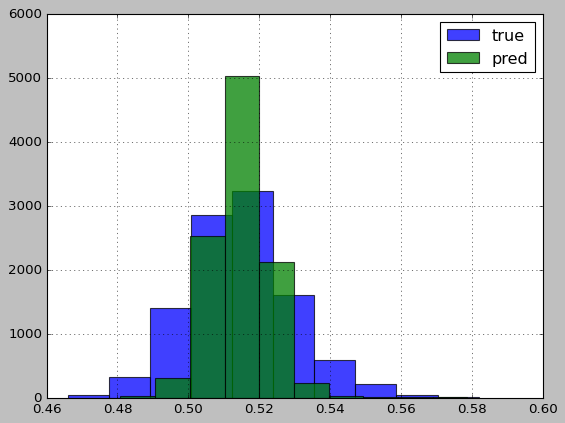

In [74]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(mdl.predict(
    test_data.loc[:, train_data.columns != 'theta_ma_future'])).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [75]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'theta_ma_prev']]


In [76]:
mdl = RandomForestRegressor().fit(
    train_data.loc[:, train_data.columns != 'theta'],
    train_data.loc[:, train_data.columns == 'theta'],
)


In [77]:
r2 = r2_score(test_data['theta'],
              mdl.predict(
                  test_data.loc[:, test_data.columns != 'theta'])
              )
print(f'R2 Score: {r2}')


R2 Score: 0.9031535597148452


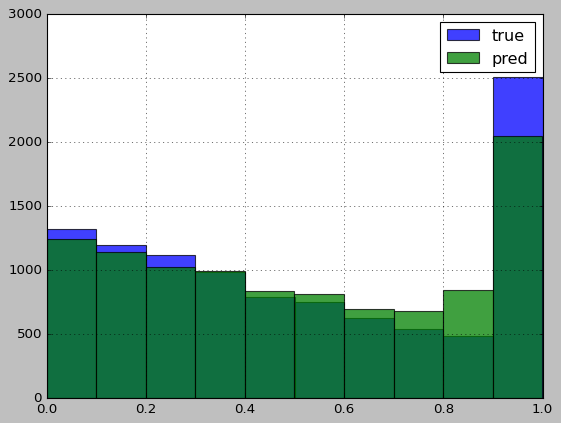

In [78]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(mdl.predict(
    test_data.loc[:, test_data.columns != 'theta'])).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


## Auto-ML

In [79]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['size', 'transaction_count', 'theta', 'congested', 'theta_ma_prev', 'theta_ma_future']]

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [80]:
# predictor = TabularPredictor(
#     label='theta_ma_future',
#     path='AutogluonModels/regression/'
# ).fit(train_data)

predictor = TabularPredictor.load("AutogluonModels/regression/")


In [81]:
predictor.leaderboard(test_data)

                 model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetTorch   -0.014273  -0.019927        0.066295       0.013952  33.085686                 0.066295                0.013952          33.085686            1       True          7
1             CatBoost   -0.014369  -0.019596        0.008804       0.001807   1.139939                 0.008804                0.001807           1.139939            1       True          4
2  WeightedEnsemble_L2   -0.014385  -0.019469        0.271860       0.055514  20.895186                 0.002859                0.000239           0.107268            2       True          8
3      NeuralNetFastAI   -0.014395  -0.019494        0.073554       0.013327  17.421824                 0.073554                0.013327          17.421824            1       True          6
4        ExtraTreesMSE   -0.015150  -0.020030

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-0.014273,-0.019927,0.066295,0.013952,33.085686,0.066295,0.013952,33.085686,1,True,7
1,CatBoost,-0.014369,-0.019596,0.008804,0.001807,1.139939,0.008804,0.001807,1.139939,1,True,4
2,WeightedEnsemble_L2,-0.014385,-0.019469,0.271860,0.055514,20.895186,0.002859,0.000239,0.107268,2,True,8
3,NeuralNetFastAI,-0.014395,-0.019494,0.073554,0.013327,17.421824,0.073554,0.013327,17.421824,1,True,6
4,ExtraTreesMSE,-0.015150,-0.020030,0.221276,0.038914,0.651485,0.221276,0.038914,0.651485,1,True,5
5,RandomForestMSE,-0.015206,-0.020075,0.186643,0.040141,2.226155,0.186643,0.040141,2.226155,1,True,3
6,KNeighborsUnif,-0.016885,-0.022168,0.016975,0.007262,0.012152,0.016975,0.007262,0.012152,1,True,1
7,KNeighborsDist,-0.017574,-0.023070,0.016727,0.005272,0.008742,0.016727,0.005272,0.008742,1,True,2


In [82]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: 0.0544987971581381


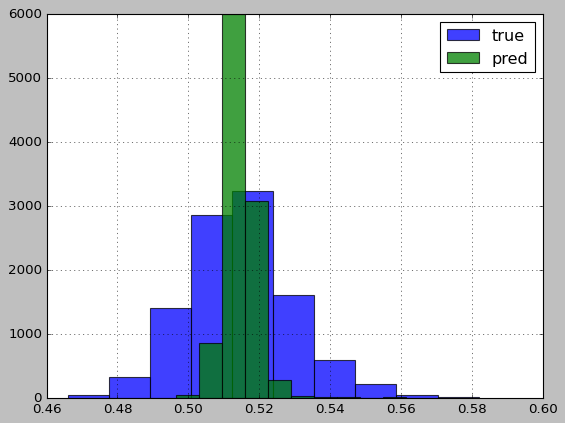

In [83]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [87]:
train_data = pd.read_pickle('data/regression_train_df.pkl')[
    ['theta', 'theta_ma_prev', 'theta_ma_future']]
test_data = pd.read_pickle('data/regression_test_df.pkl')[
    ['theta', 'theta_ma_prev', 'theta_ma_future']]

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

In [88]:
predictor = TabularPredictor(
    label='theta_ma_future',
    path='AutogluonModels/regression_theta/'
).fit(train_data)

# predictor = TabularPredictor.load("AutogluonModels/regression_theta/")


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression_theta/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52578
Train Data Columns: 2
Label Column: theta_ma_future
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.6945601391516564, 0.43222634553184464, 0.51463, 0.01769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3551.04 MB
	Train Data (Original)  Memory Usage: 0.84 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set

In [89]:
r2 = r2_score(test_data['theta'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: 0.013112817949940792


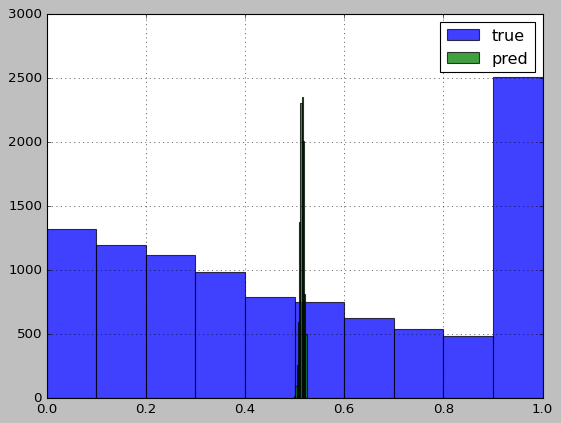

In [90]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


# Regression with Volatility

In [91]:
train_data = pd.read_pickle('data/train_volatility.pkl')[
    ['theta', 'congested', 'theta_ma_prev', 'theta_ma_future', 'volatility']]
test_data = pd.read_pickle('data/test_volatility.pkl')[
    ['theta', 'congested', 'theta_ma_prev', 'theta_ma_future', 'volatility']]


In [92]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [93]:
predictor = TabularPredictor(
    label='theta_ma_future',
    path='AutogluonModels/regression-volatility/'
).fit(train_data)

# predictor = TabularPredictor.load("AutogluonModels/regression-volatility/")


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression-volatility/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52329
Train Data Columns: 4
Label Column: theta_ma_future
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.6945601391516564, 0.43222634553184464, 0.51465, 0.01771)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3518.25 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values

In [94]:
predictor.leaderboard(test_data)


                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetTorch   -0.014790  -0.017981        0.061757       0.019512  337.780722                 0.061757                0.019512         337.780722            1       True          7
1      NeuralNetFastAI   -0.015047  -0.017873        0.074070       0.020081   71.397219                 0.074070                0.020081          71.397219            1       True          6
2        ExtraTreesMSE   -0.015457  -0.017059        0.172259       0.040072    1.320572                 0.172259                0.040072           1.320572            1       True          5
3       KNeighborsUnif   -0.016341  -0.019753        0.019073       0.007149    0.024554                 0.019073                0.007149           0.024554            1       True          1
4  WeightedEnsemble_L2   -0.016393  -0.0

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-0.014790,-0.017981,0.061757,0.019512,337.780722,0.061757,0.019512,337.780722,1,True,7
1,NeuralNetFastAI,-0.015047,-0.017873,0.074070,0.020081,71.397219,0.074070,0.020081,71.397219,1,True,6
2,ExtraTreesMSE,-0.015457,-0.017059,0.172259,0.040072,1.320572,0.172259,0.040072,1.320572,1,True,5
3,KNeighborsUnif,-0.016341,-0.019753,0.019073,0.007149,0.024554,0.019073,0.007149,0.024554,1,True,1
4,WeightedEnsemble_L2,-0.016393,-0.014945,0.182909,0.045272,38.105438,0.001993,0.000246,0.112842,2,True,8
5,KNeighborsDist,-0.016668,-0.020072,0.021220,0.006442,0.024319,0.021220,0.006442,0.024319,1,True,2
6,RandomForestMSE,-0.016673,-0.015254,0.168115,0.041719,5.365845,0.168115,0.041719,5.365845,1,True,3
7,CatBoost,-0.016880,-0.015498,0.012801,0.003307,32.626751,0.012801,0.003307,32.626751,1,True,4


In [95]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: -0.21539751025632503


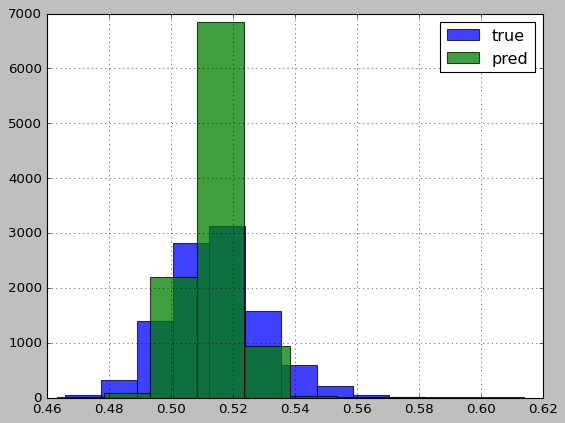

In [96]:
fig, ax = plt.subplots()

test_data['theta_ma_future'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()


### Predict Theta

In [98]:
train_data = pd.read_pickle('data/train_volatility.pkl')[
    ['theta', 'theta_ma_prev', 'theta_ma_future', 'volatility']]
test_data = pd.read_pickle('data/test_volatility.pkl')[
    ['theta', 'theta_ma_prev', 'theta_ma_future', 'volatility']]


In [99]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)


In [101]:
predictor = TabularPredictor(
    label='theta_ma_future',
    path='AutogluonModels/regression-volatility-theta/'
).fit(train_data)

# predictor = TabularPredictor.load(
#     "AutogluonModels/regression-volatility-theta/")


Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/regression-volatility-theta/"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Darwin
Train Data Rows:    52329
Train Data Columns: 3
Label Column: theta_ma_future
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.6945601391516564, 0.43222634553184464, 0.51465, 0.01771)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3511.52 MB
	Train Data (Original)  Memory Usage: 1.26 MB (0.0% of available memory)
	Inferring data type of each feature based on column 

In [102]:
predictor.leaderboard(test_data)


                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       NeuralNetTorch   -0.014874  -0.018004        0.066734       0.019991  497.241970                 0.066734                0.019991         497.241970            1       True          7
1      NeuralNetFastAI   -0.014897  -0.017902        0.080427       0.018454  173.590923                 0.080427                0.018454         173.590923            1       True          6
2        ExtraTreesMSE   -0.015407  -0.017133        0.233910       0.038800    1.227162                 0.233910                0.038800           1.227162            1       True          5
3       KNeighborsUnif   -0.016341  -0.019753        0.016994       0.005783    0.022854                 0.016994                0.005783           0.022854            1       True          1
4  WeightedEnsemble_L2   -0.016426  -0.0

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-0.014874,-0.018004,0.066734,0.019991,497.241970,0.066734,0.019991,497.241970,1,True,7
1,NeuralNetFastAI,-0.014897,-0.017902,0.080427,0.018454,173.590923,0.080427,0.018454,173.590923,1,True,6
2,ExtraTreesMSE,-0.015407,-0.017133,0.233910,0.038800,1.227162,0.233910,0.038800,1.227162,1,True,5
3,KNeighborsUnif,-0.016341,-0.019753,0.016994,0.005783,0.022854,0.016994,0.005783,0.022854,1,True,1
4,WeightedEnsemble_L2,-0.016426,-0.014939,0.243484,0.067740,687.921089,0.002297,0.000229,0.120586,2,True,8
5,KNeighborsDist,-0.016668,-0.020072,0.017643,0.006058,0.022796,0.017643,0.006058,0.022796,1,True,2
6,RandomForestMSE,-0.016674,-0.015254,0.230548,0.044985,4.970636,0.230548,0.044985,4.970636,1,True,3
7,CatBoost,-0.016967,-0.015493,0.010639,0.022526,682.829867,0.010639,0.022526,682.829867,1,True,4


In [103]:
r2 = r2_score(test_data['theta_ma_future'].values,
              predictor.predict(
                  test_data)
              )
print(f'R2 Score: {r2}')


R2 Score: -0.22034177677096367


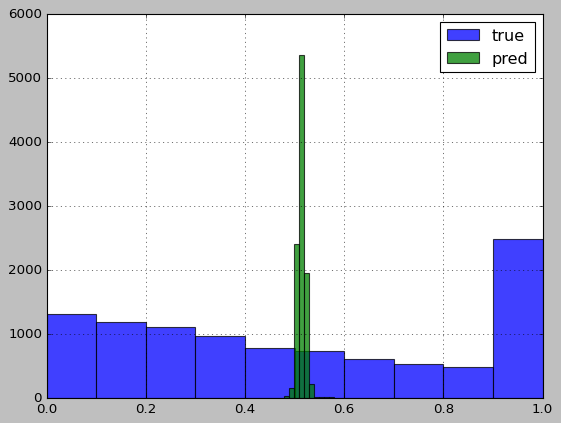

In [101]:
fig, ax = plt.subplots()

test_data['theta'].hist(ax=ax, label='true', alpha=.75)
pd.Series(predictor.predict(test_data)).hist(ax=ax, label='pred', alpha=.75)

ax.legend()
fig.show()
